In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision as tv
from PIL import Image
import cv2
from pathlib import Path
from xml.etree import ElementTree
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [23]:
import warnings
warnings.filterwarnings('ignore')

Детекция фруктов.

Датасет: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

In [24]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
#Загрузим датасет
import gdown
gdown.download('https://drive.google.com/uc?id=1itp1MtwVuF5xFnJkbErNQuDwKjEdmPvM', '34662_46346_bundle_archive.zip', quiet=True)

In [ ]:
#Разархивируем датасет с каггла
!unzip -q 34662_46346_bundle_archive.zip

In [27]:
#Кодируем классы
label_code = ['__background__', 'apple', 'orange', 'banana']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
#Меняем количество классов для предсказания
for param in model.parameters():
    param.requires_grad = False
num_class = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_class)

In [29]:
# Предобработка датасета
class FrutDataset (torch.utils.data.Dataset):
    def __init__(self, path, mode):
        self.path = path 
        self.mode = mode
        path = Path(path)
        if mode == "train":
            _path = path /'train_zip'/'train'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        elif mode == "test":
            _path = path/'test_zip'/'test'
            self.img_lst = list(sorted(_path.glob("*.jpg")))
            self.xml_lst = list(sorted(_path.glob("*.xml")))
        else:
            raise ValueError('Incorrect mode')
    
    def __len__(self):
        return len(self.img_lst)

    def __getitem__(self, index):
        img = self.img_lst[index]
        label = self.xml_lst[index]
        pil = Image.open(img).convert('RGB')
        if self.mode == "train":
            #Трансофрмации
            rndlist = [tv.transforms.ColorJitter(brightness=(0, 1),
                                                 contrast=(0, 1),
                                                 saturation=(0, 1)),
                        tv.transforms.RandomGrayscale(p=0.1)]
            transform = tv.transforms.Compose([
                                            tv.transforms.RandomChoice(rndlist),
                                            tv.transforms.ToTensor()])
            x = transform(pil)
        else:
            x = tv.transforms.ToTensor()(pil)
        #Извлечем координаты из xml
        tr = ElementTree.parse(label)
        root = tr.getroot()
        name = []
        coord = []
        labels_code = ['__background__','apple', 'orange', 'banana']
        for element in root.iter('object'):
            tempcoord = []
            for child in element:
                if child.tag == 'name':
                    name += [labels_code.index(child.text)]
                elif child.tag == 'bndbox':
                    for i in child:
                        tempcoord +=[int(i.text)]
                    coord +=[tempcoord]
        coord = torch.LongTensor(coord)
        name = torch.LongTensor(name)
        label = {'boxes':coord , 'labels': name}
        return (x, label)

In [30]:
# Создаем обучающий и валидационный сеты.
train_set = FrutDataset(path = '/content', mode='train')
val_set = FrutDataset(path = '/content', mode='test')

In [31]:
# Для приведения батча к требуемому виду.
def my_collate(batch):
    image = [i[0].to(device) for i in batch]
    target = [i[1] for i in batch]
    target = [{k: v.to(device) for k, v in t.items()} for t in target]
    return image, target

In [32]:
# Загрузчики
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True, collate_fn=my_collate)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, 
                                         shuffle=False, collate_fn=my_collate)

In [33]:
optim = torch.optim.AdamW(model.parameters(), amsgrad=True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3, gamma=0.1)

In [ ]:
model.to(device)

In [35]:
def train_one_epoch(model, optimizer, train_set):
    model.train()
    epoch_loss = 0
    for images, targets in train_set:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f'loss for {epoch} epoch {epoch_loss}')
    return epoch_loss

In [36]:
def iou (box_true, box_pred):
    '''
    box_true - [x1,y1,x2,y2]
    box_pred - [x1,y1,x2,y2]
    '''
    x1i = max(box_true[0],box_pred[0])
    y1i = max(box_true[1],box_pred[1])
    x2i = min(box_true[2],box_pred[2])
    y2i = min(box_true[3],box_pred[3])
    # Пересечение
    intersection = abs(y2i-y1i)*abs(x2i-x1i)
    box_true_area = (box_true[2]-box_true[0])*(box_true[3]-box_true[1])
    box_pred_area = (box_pred[2]-box_pred[0])*(box_pred[3]-box_pred[1])
    # Объединение
    union = box_true_area+box_pred_area-intersection
    iou = intersection/(union+0.000001)
    return iou.item()

In [37]:
def validation (model, val_loader):
    model.eval()
    frame = pd.DataFrame({'class_name': label_code[1:], 'TP': 0, 'FP': 0, 'FN': 0})
    with torch.no_grad():
        for x, y_true in val_loader:
            x = x[0].unsqueeze(0)
            y_pred = model(x)
            for i in torch.unique(y_pred[0]['labels']):
                # Отсечем предсказания, 
                # в точности которых модель уверена менее чем на 50%
                pred_boxes = y_pred[0]['boxes'][(y_pred[0]['labels'] == i) &
                                                (y_pred[0]['scores'] > 0.5)]
                true_boxes = y_true[0]['boxes'][y_true[0]['labels']==i]
                # Если модель уверена менее чем на 50% в ответе,
                # значит детекции не произошло
                if len(pred_boxes) == 0:
                    frame.at[i.item()-1, 'FN'] += 1
                    continue
                #Если нашла классы, которых нет на картинке
                if len(true_boxes) == 0:
                    frame.at[i.item()-1, 'FN'] += len(pred_boxes)
                    continue
                iou_matrix = []
                # Подсчет IoU
                for t_box in true_boxes:
                    t_box_iou = []
                    for p_box in pred_boxes:
                        t_box_iou.append(iou(t_box,p_box))
                    iou_matrix.append(t_box_iou)
                iou_matrix=torch.FloatTensor(iou_matrix)
                iou_matrix[iou_matrix>1]=0 
                # Максимальный iou>0.5 по строкам считаем TP
                TP = torch.sum(iou_matrix.max(-1, keepdim=True)[0]>0.5).item()
                frame.at[i.item()-1, 'TP'] += TP
                # Количество FP
                FP = abs(TP - iou_matrix.shape[1])
                frame.at[i.item()-1, 'FP'] += FP
                # Если true box не задетектирован: FN
                FN = iou_matrix.shape[0] - TP
                frame.at[i.item()-1, 'FN'] += FN
        # Метрики
        frame['precision'] = frame['TP']/(frame['TP']+frame['FP'])
        frame['recall'] = frame['TP']/(frame['TP']+frame['FN'])
        frame['F1'] = 2 * (frame['precision']*frame['recall'])/(frame['precision']+frame['recall'])
    return frame

In [ ]:
# Обучим присоединенные к модели части.
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 10
save_point = 0
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    if epoch % 2 == 0:
        val_metrics = validation(model, val_loader)
        print(val_metrics)
    if val_metrics.F1.sum() > save_point:
        torch.save(model.state_dict(), path_for_save)
        save_point = total_loss
    lr_scheduler.step()

In [39]:
# Заморозим обученную часть и разморозим backbone.
for param in model.parameters():
    param.requires_grad = False
for param in model.backbone.parameters():
    param.requires_grad = True

In [ ]:
# Обучим backbone.
path_for_save = '/content/drive/My Drive/Fruit_detection/model_params.pth'
num_epochs = 15
save_point = 0
for epoch in range(num_epochs):
    total_loss = train_one_epoch(model, optim, train_loader)
    if epoch % 2 == 0:
        val_metrics = validation(model, val_loader)
        print(val_metrics)
    if val_metrics.F1.sum() > save_point:
        torch.save(model.state_dict(), path_for_save)
        save_point = total_loss
    lr_scheduler.step()

Если ранее уже обучали

In [41]:
path_for_load = '/content/drive/My Drive/Fruit_detection/model_params.pth'
if Path(path_for_load).exists():
    model.load_state_dict(torch.load(path_for_load, map_location=device))

Проверим модель на изображении

--2020-07-17 17:16:38--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227231 (222K) [image/jpeg]
Saving to: ‘800px-Apples.jpg’

800px-Apples.jpg    100%[===================>] 221.91K  --.-KB/s    in 0.02s   

2020-07-17 17:16:38 (13.4 MB/s) - ‘800px-Apples.jpg’ saved [227231/227231]



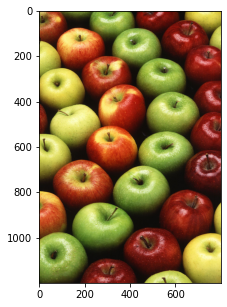

In [42]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Apples.jpg/800px-Apples.jpg
pilimg = Image.open('/content/800px-Apples.jpg')
plt.figure(figsize=(10,5))
plt.imshow(pilimg);

In [52]:
def plot_preds(pilimg, predict):
    numimg = np.array(pilimg)
    boxes = predict[0]['boxes'][predict[0]['scores']>0.8].cpu().detach().numpy()
    labels = predict[0]['labels'][predict[0]['scores']>0.8].cpu().detach().numpy()
    # Переведем метки в названия
    label_code = ['__background__', 'apple', 'orange', 'banana']
    # Отрисовка
    counter=0
    for i in boxes:
        final = cv2.rectangle(numimg, (i[0],i[1]), (i[2],i[3]), color=(128, 0, 128), thickness=3)
        cv2.putText(numimg, str(label_code[labels[counter]]), (i[0],i[1]), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1.6, (0,0,0), 2)
        counter+=1
    plt.figure(figsize=(15,10))
    return plt.imshow(final)

In [46]:
# Предскажем результат.
model.eval()
img = tv.transforms.ToTensor()(pilimg).unsqueeze(0)
img = img.to(device)
predict = model(img)

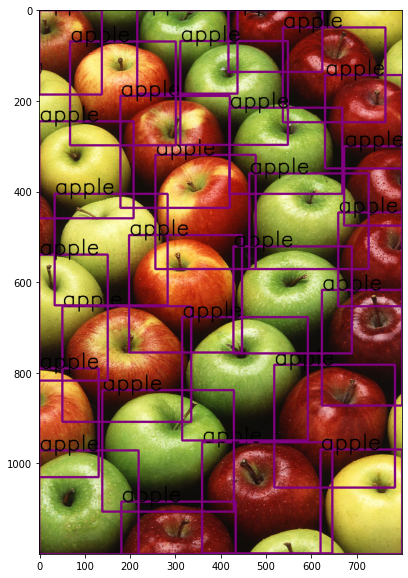

In [53]:
# Отрисовка
plot_preds(pilimg, predict)